In [13]:
# Imports

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import sklearn
import glob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from pathlib import Path

In [14]:
# Getting datasets

def get_files(dir):
    files = []
    directory = glob.glob('/Users/nathanhaudot/Desktop/jupyter/'+dir+'/*')
    
    for file in directory:
        try:
            with open(file, 'r', encoding = "ISO-8859-1") as f:
                files.append(f.read())
        except:
            pass
    
    print('{} files found in {}'.format(len(files), dir))
    return np.array(files)

# Prints datasets length
x_easy_ham = get_files('easy_ham')
x_hard_ham = get_files('hard_ham')
x_spam = get_files('spam')

2551 files found in easy_ham
250 files found in hard_ham
501 files found in spam


In [15]:
# Dataset splitting

# Resulting labels
y_easy_ham = np.ones(len(x_easy_ham))
y_hard_ham = np.ones(len(x_hard_ham))
y_all_ham = np.concatenate((y_easy_ham, y_hard_ham))
y_spam = np.ones(len(x_spam)) - 2 # -2 in order to get -1

# Concatenate ham & spam together (x & y)
x_easy_ham_spam = np.concatenate((x_easy_ham, x_spam))
x_hard_ham_spam = np.concatenate((x_hard_ham, x_spam))

y_easy_ham_spam = np.concatenate((y_easy_ham, y_spam))
y_hard_ham_spam = np.concatenate((y_hard_ham, y_spam))

# All ham
x_ham = np.concatenate((x_easy_ham, x_hard_ham))
x_all_ham_spam = np.concatenate((x_ham, x_spam))
y_all_ham_spam = np.concatenate((y_all_ham,y_spam))

# Splitting data
X_easy_train, X_easy_test, Y_easy_train, Y_easy_test = train_test_split(x_easy_ham_spam, y_easy_ham_spam, test_size=0.25, random_state=6)
X_hard_train, X_hard_test, Y_hard_train, Y_hard_test = train_test_split(x_hard_ham_spam, y_hard_ham_spam, test_size=0.25, random_state=6)
X_all_train, X_all_test, Y_all_train, Y_all_test = train_test_split(x_all_ham_spam, y_all_ham_spam, test_size=0.25, random_state=6)

In [16]:
# Vectorizing datas

# Get most frequent words
filtered_vectorizer = CountVectorizer().fit(X_all_train)
bag_of_words = filtered_vectorizer.transform(X_all_train)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in filtered_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Extract most frequent words into list (stopwords)
stopwords = []
for word in words_freq[:500]:
    stopwords.append(word[0])
    
stopwords = frozenset(stopwords)

# Taking stopwords into account in the CountVectorizer
filtered_vectorizer = CountVectorizer(stop_words=stopwords)

# Easy spam
X_easy_train = filtered_vectorizer.fit_transform(X_easy_train)
X_easy_test = filtered_vectorizer.transform(X_easy_test)

# Hard spam
X_hard_train = filtered_vectorizer.fit_transform(X_hard_train)
X_hard_test = filtered_vectorizer.transform(X_hard_test)

# All ham spam
X_all_train = filtered_vectorizer.fit_transform(X_all_train)
X_all_test = filtered_vectorizer.transform(X_all_test)

Multinomial
[[116  19]
 [  1 690]] : is the confusion matrix
0.9758 : is the accuracy score
0.9732 : is the precision score
0.9986 : is the recall score
0.9857 : is the f1 score

Bernouilli
[[ 15 120]
 [  0 691]] : is the confusion matrix
0.8547 : is the accuracy score
0.852 : is the precision score
1.0 : is the recall score
0.9201 : is the f1 score


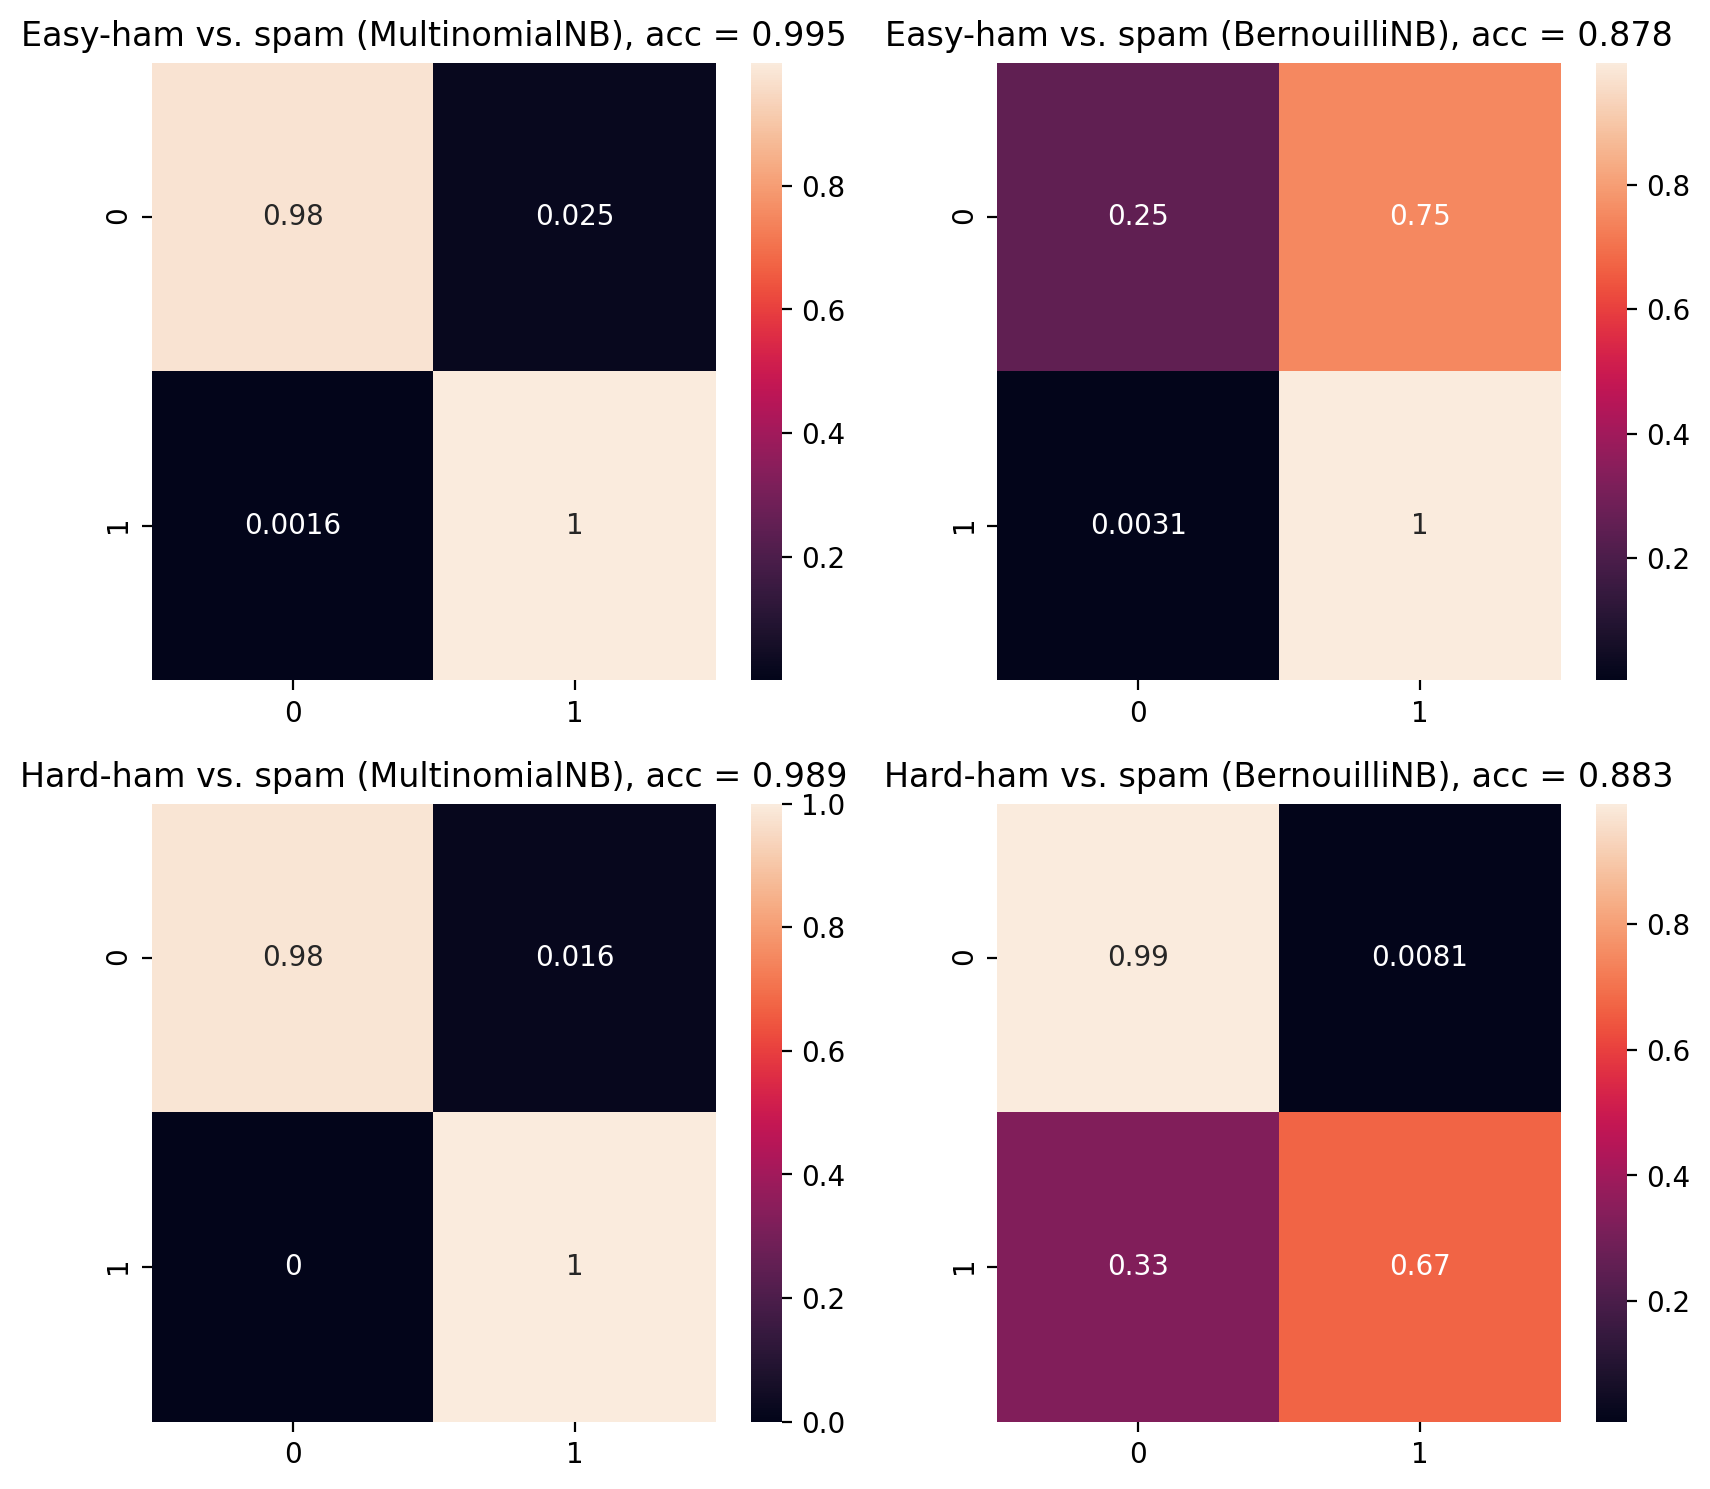

In [17]:
# Trainning on ham easy/hard & spam

# Multinomial Naive Bayes
multinomial_nb = MultinomialNB()

Y_easy_pred = multinomial_nb.fit(X_easy_train, Y_easy_train).predict(X_easy_test)
Y_hard_pred = multinomial_nb.fit(X_hard_train, Y_hard_train).predict(X_hard_test)
Y_all_pred = multinomial_nb.fit(X_all_train, Y_all_train).predict(X_all_test)

# Bernouilli Naive Bayes
bernouilli_nb = BernoulliNB()

Y_easy_pred_bern = bernouilli_nb.fit(X_easy_train, Y_easy_train).predict(X_easy_test)
Y_hard_pred_bern = bernouilli_nb.fit(X_hard_train, Y_hard_train).predict(X_hard_test)
Y_all_pred_bern = bernouilli_nb.fit(X_all_train, Y_all_train).predict(X_all_test)

# Confusion matrixes & accuracies
cm_easy = confusion_matrix(Y_easy_test, Y_easy_pred)
ac_easy = accuracy_score(Y_easy_test,Y_easy_pred)
ac_easy = round(ac_easy, 3)
cm_hard = confusion_matrix(Y_hard_test, Y_hard_pred)
ac_hard = accuracy_score(Y_hard_test,Y_hard_pred)
ac_hard = round(ac_hard, 3)
cm_easy_bern = confusion_matrix(Y_easy_test, Y_easy_pred_bern)
ac_easy_bern = accuracy_score(Y_easy_test,Y_easy_pred_bern)
ac_easy_bern = round(ac_easy_bern, 3)
cm_hard_bern = confusion_matrix(Y_hard_test, Y_hard_pred_bern)
ac_hard_bern = accuracy_score(Y_hard_test,Y_hard_pred_bern)
ac_hard_bern = round(ac_hard_bern, 3)

# Normalized confusion matrixes
cm_easy_norm = cm_easy.astype('float') / cm_easy.sum(axis=1)[:, np.newaxis]
cm_hard_norm = cm_hard.astype('float') / cm_hard.sum(axis=1)[:, np.newaxis]

cm_easy_bern_norm = cm_easy_bern.astype('float') / cm_easy_bern.sum(axis=1)[:, np.newaxis]
cm_hard_bern_norm = cm_hard_bern.astype('float') / cm_hard_bern.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrixes & accuracies
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2, 2, figsize=(10,9), dpi=200) # create 2 columns for subplots

ax1 = sn.heatmap(cm_easy_norm, annot=True, ax=ax1)
ax1.title.set_text('Easy-ham vs. spam (MultinomialNB), acc = ' + str(ac_easy))
ax3 = sn.heatmap(cm_hard_norm, annot=True, ax=ax3)
ax3.title.set_text('Hard-ham vs. spam (MultinomialNB), acc = ' + str(ac_hard))
ax2 = sn.heatmap(cm_easy_bern_norm, annot=True, ax=ax2)
ax2.title.set_text('Easy-ham vs. spam (BernouilliNB), acc = ' + str(ac_easy_bern))
ax4 = sn.heatmap(cm_hard_bern_norm, annot=True, ax=ax4)
ax4.title.set_text('Hard-ham vs. spam (BernouilliNB), acc = ' + str(ac_hard_bern))

# Information on classifiers
def get_info(model, x_test_vec_, y_test_):
    y_pred = []
    for i in range(0, x_test_vec_.shape[0]):
        sample = x_test_vec_[i, :]
        pred = model.predict(sample)
        y_pred.append(pred)
    y_pred = np.array(y_pred)
    print(confusion_matrix(y_test_, y_pred), ": is the confusion matrix")
    print(round(accuracy_score(y_test_, y_pred),4), ": is the accuracy score")
    print(round(precision_score(y_test_, y_pred), 4), ": is the precision score")
    print(round(recall_score(y_test_, y_pred), 4), ": is the recall score")
    print(round(f1_score(y_test_, y_pred), 4), ": is the f1 score") # f1 is a mix of accuracy and recall
    
print('Multinomial')
get_info(multinomial_nb, X_all_test, Y_all_test)
print('\nBernouilli')
get_info(bernouilli_nb, X_all_test, Y_all_test)

In [18]:
# Hyperoptimisation training

# Hyperparameters grid
param_grid_nb_multi = {
    'alpha': [1,0.1,0.01,0.001,0.0001,0]
}
param_grid_nb_bernoulli = {
    'alpha': [1,0.1,0.01,0.001,0.0001,0],
    'binarize': [1, 0.8, 0.5, 0.3, 0.1, 0.001]
}

print("[*] Starting hyperoptimization for Multinomial ..")
nbMultinomial_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb_multi, verbose=1, cv=10, n_jobs=-1).fit(X_all_train, Y_all_train)
print("[!] Best estimator {} ".format(nbMultinomial_grid.best_estimator_))

print("[*] Starting hyperoptimization for Bernoulli ..")
nbBernoulli_grid = GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid_nb_bernoulli, verbose=1, cv=10, n_jobs=-1).fit(X_all_train, Y_all_train)
print("[!] Best estimator {} ".format(nbBernoulli_grid.best_estimator_))

multinomial_nb = nbMultinomial_grid.best_estimator_
bernoulli_nb = nbBernoulli_grid.best_estimator_

[*] Starting hyperoptimization for Multinomial ..
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[!] Best estimator MultinomialNB(alpha=0.1) 
[*] Starting hyperoptimization for Bernoulli ..
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[!] Best estimator BernoulliNB(alpha=0.001, binarize=1) 
